# What Makes an NBA All-Star?
by Darren Tsang, darrentsang@ucla.edu

TL;DR:
- excelling in only one stat is not enough to be an All-Star, players should focus on performing at least average in every stat category
- having a high amount of points is by far the most important to becoming an All-Star, though not the end all be all (see point 1)
- there is no clear advantage in playing on any particular team

### Introduction

Around the midpoint of every season, the NBA hosts the All-Star Weekend (ASW). There are a variety of events throughout ASW, such as the 3-Point Contest, Dunk Contest, and Celebrity Game. The ASW serves as a welcome break for players in a long, physically-draining season.

The weekend culminates in the All-Star Game (ASG), which is arguably the most anticipated event. The ASG features the league's 24 best and most popular players. The starters are chosen through a weighted voting process: fan voting accounting for 50%, player voting accounting for 25%, and media voting accounting for 25%. The reserves are then chosen by the league's coaches. Thus, in order to maximize the likelihood of being selected, it is in the players' best interest to perform well on the court and have a loyal following off the court. 

In this project, I aim to explore if there are any indicators to whether a player is an All-Star or not. To do this, I go through an end-to-end machine learning pipeline, beginning with data collection to data modeling. Knowing what to focus on to maximize likelihood of being an All-Star may be advantageous to an NBA player because participating in the ASG can have great positive impact on a player's career trajectory on and off the court.


Note: Coloquially, an *All-Star* is a player that qualifies to play in the ASG. For example, one would say "Stephen Curry was an *All-Star* in the 2018-2019 NBA season".


### Data Collection

Before we can do any data analysis / modeling, we need data. To compile the dataset for this project, I will mainly be using an NBA API (https://github.com/swar/nba_api) to collect the stats of current NBA players.

In [1]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats, commonplayerinfo

import pandas as pd
import numpy as np
import time
import sys

pd.set_option("display.max_rows", None, "display.max_columns", None)

*create_all_star()* is a helper function that creates a list containing 0's and 1's. A 0 represents a non all-star season, and a 1 represents an all-star season.

This function is necessary because there are two datasets feteched from the NBA API; one with all seasons, and one with only the playoff seasons. The returned list is of the same length as the number of seasons for that particular player. 

In [2]:
def create_all_star(all_seasons, all_star_seasons):
    all_star_status = [0] * len(all_seasons)
    for i in range(len(all_seasons)):
        if(all_seasons[i] in all_star_seasons):
            all_star_status[i] = 1
    return(all_star_status)

The next chunk of code is used to collect the data using the NBA API. It iterates through every active NBA player and creates a dataset, called *all_data*, that contains the stats of every active player's seasons. Note that I created an *ALL-STAR* column, which represents if that season was an all-star season.

In [3]:
all_players = players.get_active_players() # get list of all active players
all_data = pd.DataFrame(columns = ['NAME', 'ALL-STAR', 'PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID',
                        'TEAM_ABBREVIATION', 'PLAYER_AGE', 'GP', 'GS', 'MIN',
                        'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                        'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB',
                        'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'])

start = time.time()
for player in all_players: # iterate through every active player
#     print(player['full_name'])
    time.sleep(1.5) # prevent too many requests at once
    career = playercareerstats.PlayerCareerStats(player_id=player['id']).get_data_frames()
    stats = career[0]
    
    all_star = create_all_star(list(stats['SEASON_ID']), (list(career[4]['SEASON_ID'])))
    stats['NAME'] = [player['full_name']] * stats.shape[0]
    stats['ALL-STAR'] = all_star

    for i in range(stats.shape[0]):
        all_data = all_data.append(stats.iloc[[i]], ignore_index=True)

print('Took {} seconds to collect data!'.format(time.time() - start))

Took 1173.485113143921 seconds to collect data!


In [4]:
all_data.shape

(3434, 29)

### Data Cleaning

Quick check shows that there are no null values in our dataset.

In [5]:
all_data.isnull().values.any()

False

In [6]:
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3434 entries, 0 to 3433
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NAME               3434 non-null   object 
 1   ALL-STAR           3434 non-null   object 
 2   PLAYER_ID          3434 non-null   object 
 3   SEASON_ID          3434 non-null   object 
 4   LEAGUE_ID          3434 non-null   object 
 5   TEAM_ID            3434 non-null   object 
 6   TEAM_ABBREVIATION  3434 non-null   object 
 7   PLAYER_AGE         3434 non-null   float64
 8   GP                 3434 non-null   object 
 9   GS                 3434 non-null   object 
 10  MIN                3434 non-null   float64
 11  FGM                3434 non-null   object 
 12  FGA                3434 non-null   object 
 13  FG_PCT             3434 non-null   float64
 14  FG3M               3434 non-null   object 
 15  FG3A               3434 non-null   object 
 16  FG3_PCT            3434 

In [7]:
for col in ['ALL-STAR', 'GP', 'GS', 'FGM', 'FGA', 
            'FG3M', 'FG3A', 'FTM', 'FTA',
            'OREB', 'DREB', 'REB', 'AST',
            'STL', 'BLK', 'TOV', 'PF', 'PTS']:
    all_data[col] = all_data[col].astype('float64')

The datatype for some of the columns are *object* when they clearly shouldn't be. Thus, a simple fix is to iterate through the columns that need to be changed and apply the *astype()* function, as done above.

In [8]:
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3434 entries, 0 to 3433
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NAME               3434 non-null   object 
 1   ALL-STAR           3434 non-null   float64
 2   PLAYER_ID          3434 non-null   object 
 3   SEASON_ID          3434 non-null   object 
 4   LEAGUE_ID          3434 non-null   object 
 5   TEAM_ID            3434 non-null   object 
 6   TEAM_ABBREVIATION  3434 non-null   object 
 7   PLAYER_AGE         3434 non-null   float64
 8   GP                 3434 non-null   float64
 9   GS                 3434 non-null   float64
 10  MIN                3434 non-null   float64
 11  FGM                3434 non-null   float64
 12  FGA                3434 non-null   float64
 13  FG_PCT             3434 non-null   float64
 14  FG3M               3434 non-null   float64
 15  FG3A               3434 non-null   float64
 16  FG3_PCT            3434 

Next, I remove the current season's data (*2020-21*) because the season has just started very recently, and there won't be enough data yet. I also removed the rows where the team was *TOT*, which is used when a player has been traded mid-seasom; *TOT* represents the total stats of player in such cases. Lastly, I removed the columns that are just IDs, which are just unique identifiers assigned arbitrarily.

In [9]:
all_data = all_data[all_data.SEASON_ID != '2020-21'].reset_index(drop = True)

In [10]:
all_data = all_data[all_data.TEAM_ABBREVIATION != 'TOT'].reset_index(drop = True)

In [11]:
all_data = all_data.drop(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID'], axis=1)

In [12]:
all_data.sample(5, random_state=999)

,NAME,ALL-STAR,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
2178,Theo Pinson,0.0,BKN,23.0,18.0,0.0,211.0,25.0,73.0,0.342,12.0,46.0,0.261,19.0,22.0,0.864,4.0,32.0,36.0,21.0,6.0,0.0,18.0,15.0,81.0
733,Luka Doncic,0.0,DAL,20.0,72.0,72.0,2318.0,506.0,1186.0,0.427,168.0,514.0,0.327,346.0,485.0,0.713,86.0,477.0,563.0,429.0,77.0,25.0,247.0,137.0,1526.0
895,Tim Frazier,0.0,DET,29.0,27.0,11.0,355.0,34.0,94.0,0.362,10.0,30.0,0.333,19.0,24.0,0.792,9.0,24.0,33.0,93.0,14.0,4.0,36.0,42.0,97.0
145,Marvin Bagley III,0.0,SAC,21.0,13.0,6.0,334.0,78.0,167.0,0.467,4.0,22.0,0.182,25.0,31.0,0.806,29.0,68.0,97.0,10.0,6.0,12.0,18.0,43.0,185.0
327,Avery Bradley,0.0,BOS,21.0,64.0,28.0,1368.0,200.0,402.0,0.498,22.0,54.0,0.407,62.0,78.0,0.795,34.0,81.0,115.0,87.0,43.0,12.0,75.0,109.0,484.0


The *PLAYER_AGE* column is renamed to *AGE* for aesthetics. 

In [13]:
all_data.rename(columns={'PLAYER_AGE':'AGE'}, inplace=True)

*TEAM_FTR* is a factorized version of *TEAM_ABBREVIATION*. This is done so that it's easier to work with players' teams in the future.

In [14]:
all_data['TEAM_FTR'] = pd.factorize(all_data['TEAM_ABBREVIATION'])[0]

In [15]:
all_data.shape

(2810, 26)

Our final dataset has 2810 rows and 26 columns. Before cleaning our data, there were 3430 rows and 29 columns.

### Exploratory Data Analysis (EDA)

Next, I perform some EDA on our cleaned dataset to gain a better understanding of the data I'm working with. A quick way to gain a lot of information is through the use of graphs and plots.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15, 7]
sns.set_palette("deep")

In [17]:
all_data_melt_common_stats = all_data.melt(id_vars = 'ALL-STAR',
                                           value_vars = ['PTS', 
                                                         'AST',
                                                         'REB',
                                                         'STL',
                                                         'BLK'],
                                           var_name = 'columns')

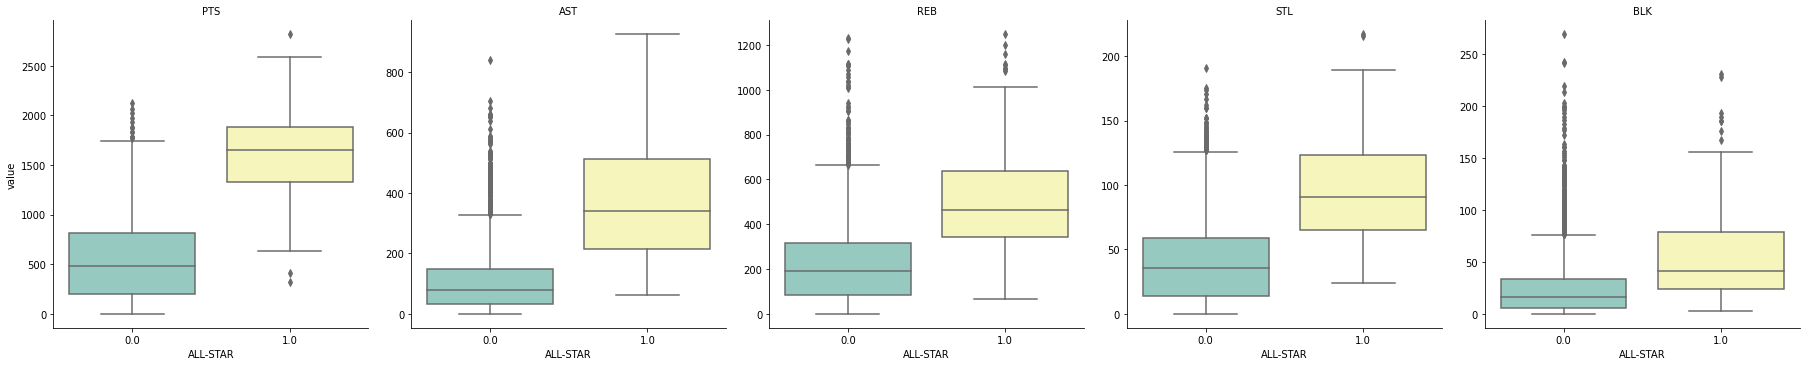

In [18]:
sns.catplot(data = all_data_melt_common_stats,
            x = 'ALL-STAR',
            y = 'value',
            sharey = False,
            kind = 'box',
            col = 'columns',
            palette='Set3',
            col_order = ['PTS',
                         'AST',
                         'REB',
                         'STL',
                         'BLK']
           ).set_titles('{col_name}') # remove 'column = ' part of title

I created 5 boxplots of amount of points, assists, rebounds, steals, and blocks split by whether it was an all-star season or not. From the plots, it appears that all-star seasons have higher points, assists, rebounds, steals, and blocks, which makes intutive sense.

One thing to note is that there are a lot of outliers for all of the 5 stats for the non all-star seasons, while there are only a few outliers for the all-star seasons. This is seen graphically as the dots above / below the horizontal lines. For example, if we take a look at the PTS plot, there's a bunch of outliers with high amount of points in non all-star seasons, as seen by the group of points from ~1750 to ~2250. On the other hand, for the all-star seasons there is only a small group of points around ~2750 and another around ~450 to ~500. 

A possible interpretation is that there isn't a minimum amount of points, assists, etc. that can guarantee an all-star season. The high outliers for the non all-stars probably were not doing too well in the other stats. I think it's safe to say that a player had a season with a lot of points (for example, 2000), but was not an all-star because this player was lacking in the other stats.

In [19]:
all_data_melt_teams = all_data.melt(id_vars = 'TEAM_ABBREVIATION',
                                    value_vars = ['ALL-STAR'],
                                    var_name = 'columns')[['TEAM_ABBREVIATION', 'value']]
all_data_melt_teams = all_data_melt_teams.groupby('TEAM_ABBREVIATION', as_index=False).agg({"value": "sum"})
all_data_melt_teams.head()

,TEAM_ABBREVIATION,value
0,ATL,11.0
1,BKN,2.0
2,BOS,10.0
3,CHA,3.0
4,CHI,5.0


<AxesSubplot:xlabel='TEAM_ABBREVIATION', ylabel='value'>

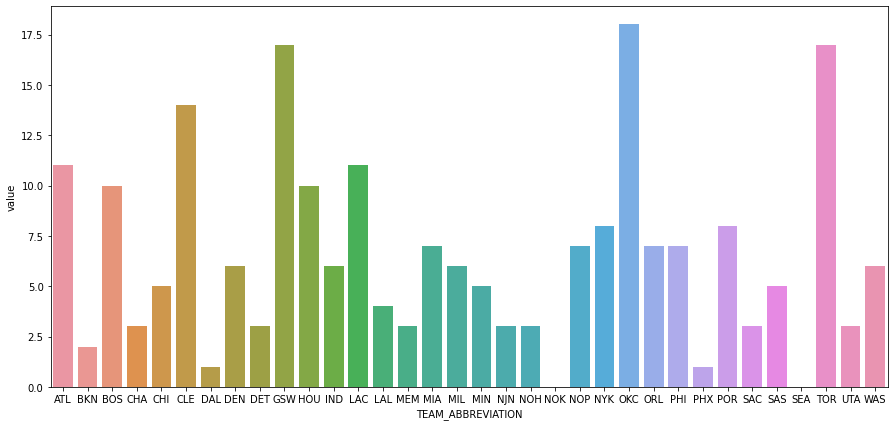

In [20]:
sns.barplot(data=all_data_melt_teams, x='TEAM_ABBREVIATION', y='value')

Next, I created a plot that shows the amount of all-star seasons for each team. Note that currently, there are only 30 teams in the NBA, but the plot shows 33 teams. This discrepency is caused by past name changes.

We can see that the great majority of teams have had at least 1 active player with an all-star season. The top 3 teams in amount of all-star seasons are OKC (Oklahoma City Thunder), GSW (Golden State Warriors), and TOR (Toronto Raptors). Given the recent success of these teams' players, such as Russell Westbrook, Klay Thompson, and Demar DeRozan, it makes a lot of sense that these 3 teams have the most all-star seasons.

On the other hand, the 2 teams that don't have an all-star are NOK (New Orleans/Oklahoma City Hornets) and SEA (Seattle Supersonics). I was curious about these two teams and proceeded to do a bit more analysis, as seen below.

In [21]:
all_data[(all_data['TEAM_ABBREVIATION'] == 'NOK')]

,NAME,ALL-STAR,TEAM_ABBREVIATION,AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_FTR
505,Tyson Chandler,0.0,NOK,24.0,73.0,73.0,2525.0,292.0,468.0,0.624,0.0,1.0,0.000,106.0,201.0,0.527,320.0,584.0,904.0,66.0,37.0,129.0,126.0,244.0,690.0,32
2150,Chris Paul,0.0,NOK,21.0,78.0,78.0,2808.0,407.0,947.0,0.430,50.0,177.0,0.282,394.0,465.0,0.847,61.0,339.0,400.0,611.0,175.0,6.0,183.0,218.0,1258.0,32
2151,Chris Paul,0.0,NOK,22.0,64.0,64.0,2353.0,381.0,871.0,0.437,50.0,143.0,0.350,292.0,357.0,0.818,54.0,226.0,280.0,569.0,118.0,3.0,161.0,154.0,1104.0,32


In [22]:
all_data[(all_data['TEAM_ABBREVIATION'] == 'SEA')]

,NAME,ALL-STAR,TEAM_ABBREVIATION,AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_FTR
784,Kevin Durant,0.0,SEA,19.0,80.0,80.0,2768.0,587.0,1366.0,0.430,59.0,205.0,0.288,391.0,448.0,0.873,70.0,278.0,348.0,192.0,78.0,75.0,232.0,122.0,1624.0,33
1063,Jeff Green,0.0,SEA,21.0,80.0,52.0,2253.0,320.0,749.0,0.427,21.0,76.0,0.276,177.0,238.0,0.744,101.0,278.0,379.0,119.0,46.0,49.0,158.0,198.0,838.0,33


There are only 3 and 2 seasons for NOK and SEA respectively. This serves as an explanation as to why those two teams don't have any all-stars, since 2 and 3 seasons is a really, really low amount.

#### Principal Compenent Analysis (PCA)

Since our dataset has many columns (aka dimensions), it is impossible to graph all of the columns at once since there's no way to graph in 5-D, 6-D, 7-D, or even higher dimensions. Thus, we can use Principal Compenent Analysis (PCA) to project our data down into a 2-D / 3-D space, which makes it visualizable.

A flaw when doing PCA is that you will lose information; this is simply unavoidable when you're reducing the dimension of your data significantly. The good news is that PCA attempts to project our data in a way such that the least amount of information is lost.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
projected = pca.fit_transform(all_data.loc[:, 'AGE':'TEAM_FTR'])

Text(0, 0.5, 'PC 2')

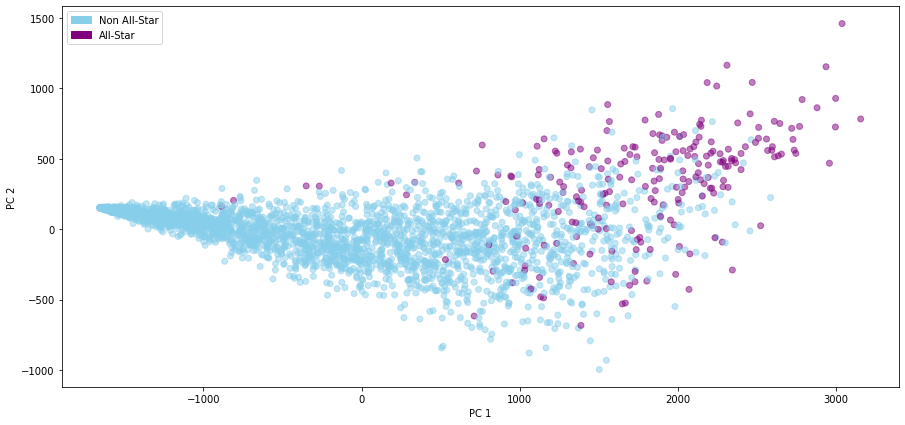

In [24]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

ax.scatter(projected[:, 0],
           projected[:, 1],
           c=['purple' if res == 1 else 'skyblue' for res in all_data.loc[:, 'ALL-STAR']], 
           marker='o',
           alpha=.5)

no = mpatches.Patch(color='skyblue', label='Non All-Star')
yes = mpatches.Patch(color='purple', label='All-Star')
ax.legend(handles=[no, yes])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

Text(0.5, 0, 'PC 3')

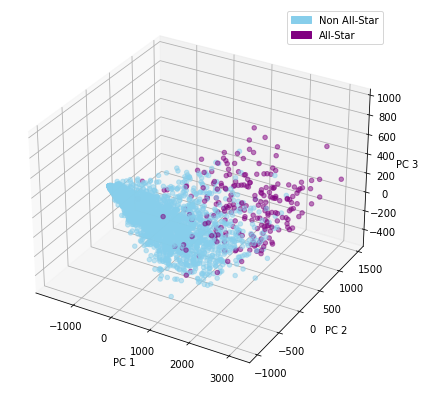

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(projected[:, 0],
           projected[:, 1], 
           projected[:, 2], 
           c=['purple' if res == 1 else 'skyblue' for res in all_data.loc[:, 'ALL-STAR']], 
           marker='o',
           alpha=.5)

no = mpatches.Patch(color='skyblue', label='Non All-Star')
yes = mpatches.Patch(color='purple', label='All-Star')
ax.legend(handles=[no, yes])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

Above are 2 plots that attempts to graph our data using PCA; the first is in 2-D, and the second is in 3-D. In both plots, the blue represents a non all-star season, while the purple represents an all-star season. 

We can see that there does seem to be a pattern that seperates the blue and the purple dots. Taking a look at the 2-D plot, the purple dots seem to form a cluster around the top right area, while the blue dots are more spread out in the left half. Focusing our attention to the 3-D plot, the purple dots form a cluster around PC 1 values of 0-1500, PC 2 values of 0-1500, and PC 3 values of 0-400.

Noticing that there are clear clusters when graphing the prinicpal components is great because this means that there is a pattern differentiating non all-star seasons from all-star seasons. With this information, we head into the modeling portion with great confidence that we can build a strong, accurate model.

### Machine Learning (Modeling)

Now that I've done some EDA to get a better understanding / develop some intution about the dataset, it's time to do some modeling. In all of these models, we want to be able to input a player's season stats and predict if that player was an all-star. Thus, the outcome is binary, with 0 representing a non all-star season and 1 representing an all-star season. The predictors are the players' stats. Since we know the outcome in our training data, this is a *supervised* machine learning problem.

#### Creating training and testing sets

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(all_data.loc[:, 'AGE':'TEAM_FTR'], 
                                                    list(all_data['ALL-STAR']), 
                                                    test_size=0.3, 
                                                    random_state=999) # set for reproducibility

In [28]:
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(1967, 23) (843, 23) 1967 843


To have an unbiased evaluation of our model's performance, I created a training and testing set. The training set is used to actually train our model, while the testing set is used after all the training has been done to evaluate how our model performs on new, unseen data. The training and testing set contain 70/30% of the overall dataset respectively.

#### k-nearest neighbors (kNN)

The first model to be applied to this dataset is k-nearest neighbros (kNN). In kNN, there isn't necessarily any training of the model. Instead, when we want to make a new prediction with predictor values $x_p$, we calculate the euclidian distance between $x_p$ and all of the other data points in our training set. Then, we predict $x_p$ to belong to the class most common among the nearest $k$ points.

The value of $k$ is usually found through hyperparamter tuning, a process of trying different values and evaluating the performance. I tried values of $k$ from $1$ to $300$ and plotted the results below.

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

scores = []
MAX_K = 300
for k in range(1, MAX_K):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

<AxesSubplot:xlabel='k', ylabel='Testing Accuracy'>

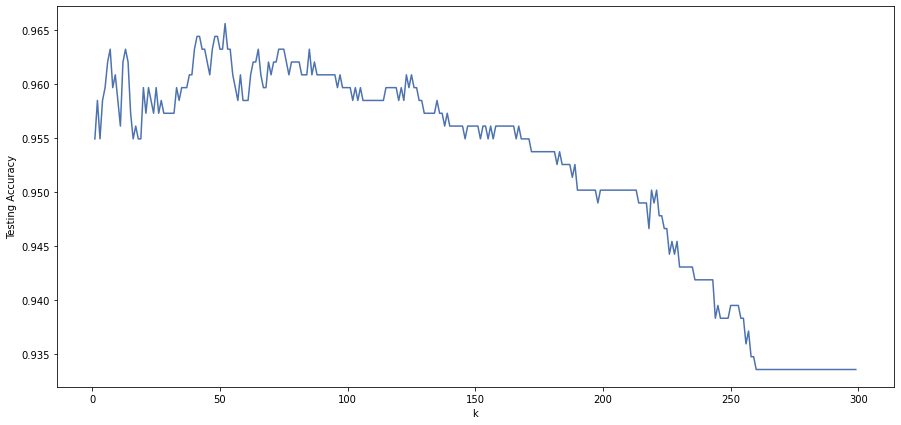

In [30]:
sns.lineplot(data = pd.DataFrame({'k':range(1, MAX_K), 'Testing Accuracy':scores}),
             x='k',
             y='Testing Accuracy')

In [31]:
knn_accuracy = max(scores)
print(scores.index(knn_accuracy) + 1, knn_accuracy)

52 0.9655990510083037


When evaluating on the testing set, the highest accuracy achieved is ~$.96560$, which is obtained when $k = 52$.

#### Logistic Regression

Logistic regression is used when the outcome is binary (yes vs no), which makes it perfect for our use case. In logistic regression, the probability that a new datapoint belongs to one of the two classes is predicted. Applied to our case, logistric regression outputs $P(ALL-STAR | x_p)$, where $x_p$ is a new observation we want to make a prediction on. If $P(ALL-STAR | x_p)$ is greater than $0.5$, we classify the new data to be an all-star seaons, else not an all-star season.


Note that $P(ALL-STAR | x_p) + P(not ALL-STAR | x_p) = 1$. 

In [32]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=100000,
                                         random_state=999)
logistic_regression.fit(X_train, y_train)


logistic_regression_pred = logistic_regression.predict(X_test) # making predictions
logistic_regression_accuracy = metrics.accuracy_score(y_test, logistic_regression_pred) # getting accuracy
logistic_regression_accuracy

0.963226571767497

Logistic regression has an accuracy of ~$.96323$ on the testing dataset.

#### Random Forest

Before I talk about random forests, I want to introduce the idea of a decision tree. A decision tree is a relatively simple algorithm that asks a series of questions to determine the outcome. For example, a decision tree that can help you decide what to bring before you leave the house is shown below.

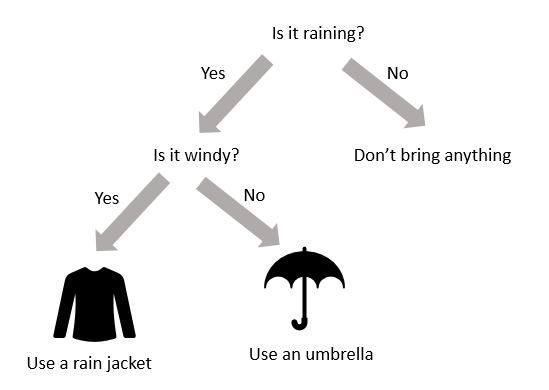

In [33]:
from IPython.display import Image
Image(filename='decision.jpeg')

Now, a decision tree on it's own isn't too powerful. This is where the idea of random forests come in; a random forest is a collection of decision trees that are trained using a bootstrap sample of our data. Then, to make a new prediction, the new data $x_p$ is run through all the decision trees and the majority class predicted from the decision trees will be the final prediction for $x_p$.

Note: A bootstrap sample is taking a sample of your dataset without replacement. This is useful to have more variety when training a decision tree. It would be pretty useless if you trained multiple decision trees using the exact same data since the final decision trees would be identical.

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, 
                            random_state=999) # set for reproducibility
rf.fit(X_train, y_train) # training model

rf_predictions = rf.predict(X_test) # making predictions
rf_accuracy = metrics.accuracy_score(y_test, rf_predictions) # getting accuracy
rf_accuracy

0.9644128113879004

Random forest has an accuracy of ~$.96441$ on the testing dataset.

<AxesSubplot:xlabel='Feature', ylabel='Importance'>

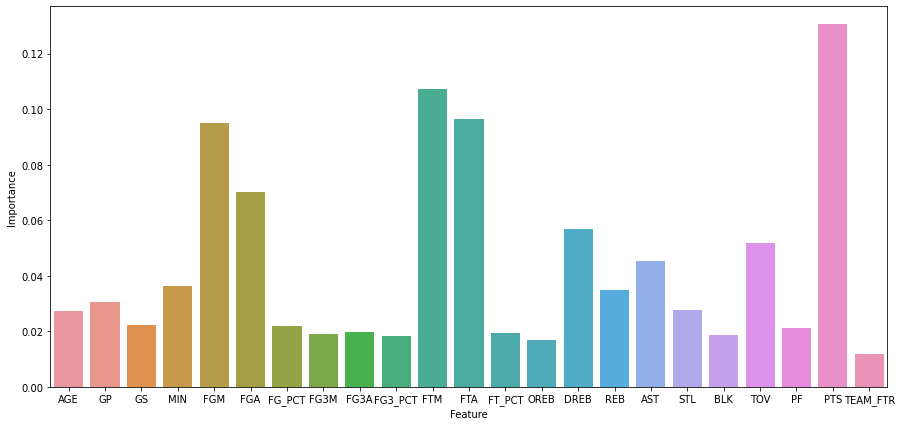

In [35]:
sns.barplot(data = pd.DataFrame({'Feature':X_train.columns, 'Importance':rf.feature_importances_}),
            x='Feature',
            y='Importance')

One of the great advantages about using tree-based methods, such as random forests, is that you can evaluate which predictors are most important. The plot above shows that PTS is by far the most important feature when predicting an all-star season. The next 4 most important features are: FTM, FGM, FGA, FTA. 

### Results / Conclusions

Here is a table summarizing our models' performance:

In [36]:
pd.DataFrame({'kNN (k = 52)':knn_accuracy, 
              'Logistic Regression':logistic_regression_accuracy,
              'Random Forest':rf_accuracy},
             index=['Testing Accuracy'])

,kNN (k = 52),Logistic Regression,Random Forest
Testing Accuracy,0.965599,0.963227,0.964413


As seen in the results table above, it is indeed very possible to accurately identify an All-Star season. Furthermore, the most important predictors are points, free throw attemped / made, and field goal attemped / made; this makes sense since free throw and field goals are necessary to have a high amount of points.